## Make fake tf to compare DH v 21cmFAST

In [32]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
from tqdm import tqdm
import pickle

import numpy as np
from scipy import interpolate

from low_energy.lowE_electrons import make_interpolator

sys.path.append("..")
from dm21cm.utils import load_dict

sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as phys

## 0. setting
1e-3 fraction of photons goes into heating. Others stay the same.

In [15]:
run_name = 'debug_230802'
abscs = load_dict(f"../data/abscissas/abscs_{run_name}.h5")
print(abscs['dlnz'])
print(len(abscs['rs']))
print(abscs['nBs'])
print(abscs['x'])
print(abscs['dep_c'])

0.04879016416943205
100
[ 0. 10.]
[0. 1.]
['H ion' 'He ion' 'exc' 'heat' 'cont' 'xray']


## 1. dm21cm tf

In [19]:
fixed_f = 1e-3

tfgv = np.zeros((100, 2, 2, 500, 500)) # rxneo
depgv = np.zeros((100, 2, 2, 500, 6)) # rxneo
hed_tf = np.zeros((100, 2, 500, 4)) # rxeo

for i_rs, rs in enumerate(abscs['rs']):
    for i_x, x in enumerate(abscs['x']):
        for i_nBs, nBs in enumerate(abscs['nBs']):
            for i_injE, injE in enumerate(abscs['photE']):
                
                hep_spec_N = np.zeros((500,))
                hep_spec_N[i_injE] = 1 - fixed_f
                
                tfgv[i_rs, i_x, i_nBs, i_injE] = hep_spec_N
                depgv[i_rs, i_x, i_nBs, i_injE, 3] = fixed_f
                dt = abscs['dlnz'] / phys.hubble(rs)
                hed_tf[i_rs, i_x, i_injE, 3] = fixed_f * abscs['photE'][i_injE] / dt

tf_type = 'phot'
save_dir = f'../data/tf/{run_name}/{tf_type}'
os.makedirs(save_dir, exist_ok=True)
np.save(f'{save_dir}/{tf_type}_tfgv.npy', tfgv)
np.save(f'{save_dir}/{tf_type}_depgv.npy', depgv)

## 2. DH tf

In [28]:
data_dir = f'../data/tf/{run_name}/{tf_type}'

In [20]:
hep_tf = tfgv[:, :, 0, :, :] # rxeo
lep_tf = np.zeros((100, 2, 500, 500))
lee_tf = np.zeros((100, 2, 500, 500))
#hed_tf = np.zeros((100, 2, 500, 4)) # see previous
cmbloss = np.zeros((100, 2, 500))

In [23]:
dlnz = abscs['dlnz']
dlnphoteng = np.log(5565952217145.328/1e-4)/500
rate = dlnz/dlnphoteng
print(rate)

0.6326848741799451


In [25]:
for i_rs in tqdm(range(len(abscs['rs']))):
    for i_x in range(len(abscs['x'])):
        tf = hep_tf[i_rs, i_x]
        rs = abscs['rs'][i_rs]
        for i_in in range(1, 500):
            tf[i_in][i_in-1] += rate
            tf[i_in][i_in]   -= rate

100%|██████████| 100/100 [00:00<00:00, 805.48it/s]


In [27]:
tfgv_dict = {
    'highengphot' : hep_tf,
    'lowengphot' : lep_tf,
    'lowengelec': lee_tf,
}

In [33]:
for name in ['highengphot', 'lowengphot', 'lowengelec']:
    print(name)
    tf = pickle.load(open(os.environ['DH_DATA_DIR']+f'/{name}_tf_interp.raw', 'rb'))
    tfgv = tfgv_dict[name]

    tf.rs_nodes = np.array([49., 1600.])
    tf._log_interp = False
    tf.dlnz = [dlnz, 0.001, 0.001]
    tf.rs[0] = abscs['rs']

    xHe_s = np.array([0., 1.])
    xHe_grid, xH_grid = np.meshgrid(xHe_s, abscs['x'])
    tf.x[0] = np.stack([xH_grid, xHe_grid], axis=-1)

    tfgv_expanded = np.repeat([tfgv], 2, axis=0)
    tfgv_xhreo = np.einsum('hrxeo -> xhreo', tfgv_expanded)
    tf.grid_vals[0] = tfgv_xhreo
    tf.interp_func[0] = interpolate.RegularGridInterpolator(
        (abscs['x'], xHe_s, abscs['rs']), tf.grid_vals[0]
    )

    pickle.dump(tf, open(f'{data_dir}/{name}_tf_interp.raw', 'wb'))

highengphot
lowengphot
lowengelec


In [34]:
tf = pickle.load(open(os.environ['DH_DATA_DIR']+'/highengdep_interp.raw', 'rb'))
tfgv = hed_tf

tf.rs_nodes = np.array([49., 1600.])
tf._log_interp = False
tf.dlnz = [dlnz, 0.001, 0.001]
tf.rs[0] = abscs['rs']

xHe_s = np.array([0., 1.])
xHe_grid, xH_grid = np.meshgrid(xHe_s, abscs['x'])
tf.x[0] = np.stack([xH_grid, xHe_grid], axis=-1)

tfgv_expanded = np.repeat([tfgv], 2, axis=0)
tfgv_xhreo = np.einsum('hrxeo -> xhreo', tfgv_expanded)
tf.grid_vals[0] = tfgv_xhreo
tf.interp_func[0] = interpolate.RegularGridInterpolator(
    (abscs['x'], xHe_s, abscs['rs']), tf.grid_vals[0]
)

pickle.dump(tf, open(f'{data_dir}/highengdep_interp.raw', 'wb'))

In [35]:
tf = pickle.load(open(os.environ['DH_DATA_DIR']+'/CMB_engloss_interp.raw', 'rb'))
tfgv = cmbloss

tf.rs_nodes = np.array([49., 1600.])
tf._log_interp = False
tf.dlnz = [dlnz, 0.001, 0.001]
tf.rs[0] = abscs['rs']

xHe_s = np.array([0., 1.])
xHe_grid, xH_grid = np.meshgrid(xHe_s, abscs['x'])
tf.x[0] = np.stack([xH_grid, xHe_grid], axis=-1)

tfgv_expanded = np.repeat([tfgv], 2, axis=0)
tfgv_xhre = np.einsum('hrxe -> xhre', tfgv_expanded)
tf.grid_vals[0] = tfgv_xhre
tf.interp_func[0] = interpolate.RegularGridInterpolator(
    (abscs['x'], xHe_s, abscs['rs']), tf.grid_vals[0]
)

pickle.dump(tf, open(f'{data_dir}/CMB_engloss_interp.raw', 'wb'))

## test

In [40]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [36]:
z = pickle.load(open(f'{data_dir}/highengdep_interp.raw', 'rb'))

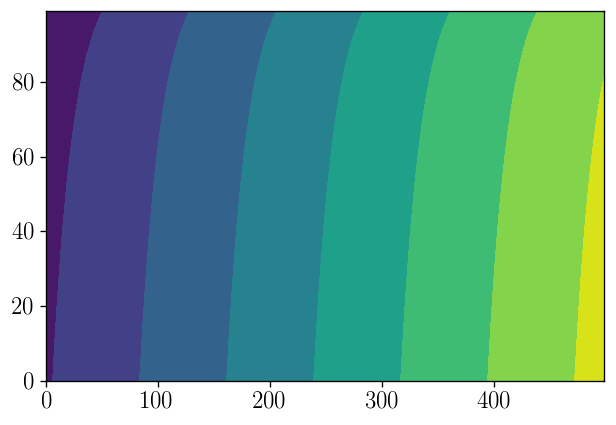

In [43]:
plt.contourf(np.flipud(np.log(z.grid_vals[0][0,0,:,:,3])))